<a href="https://colab.research.google.com/github/alyahoang99/GANs/blob/main/RGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import time
from tensorflow.keras import layers, models

In [2]:
FEATURE_DIM = 3
LATENT_DIM = 100
GRU_UNITS = 128
BATCH_SIZE = 100
EPOCHS = 500
GEN_LR = 2e-5
DISC_LR = 1e-5
BETA_1 = 0.5
DISC_UPDATES_PER_GEN = 10
LAMBDA_GP = 12.0
SEQ_LEN = 7  # Sequence length for the time steps

In [3]:
# =================== Data Preprocessing ===================
# data preprocess
# Load dataset
# Load smart meter data (Timestamp, Value, Value_HeatPump, Value_OtherAppliances)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GANs/resampleddata (1).csv', parse_dates=['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Select relevant features
features = ['Value', 'Value_HeatPump', 'Value_OtherAppliances']
data = df[features].values.astype(np.float32)

# Normalize data to [0, 1] for tanh
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

def create_sequences(data, seq_len, batchsize):
    sequences = []
    for i in range(len(data) - seq_len + 1):
        seq = data[i:i + seq_len]
        if len(seq) == seq_len:
            sequences.append(seq)
    return np.array(sequences)

real_sequences = create_sequences(data, SEQ_LEN, BATCH_SIZE)
print("Sequence data shape:", real_sequences.shape)  # (num_samples, 7, 3)

Sequence data shape: (1011, 7, 3)


In [4]:
BUFFER_SIZE = 1000  # Optional, for shuffling

dataset = tf.data.Dataset.from_tensor_slices(real_sequences)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [5]:
dataset

<_BatchDataset element_spec=TensorSpec(shape=(100, 7, 3), dtype=tf.float32, name=None)>

In [6]:
from tensorflow.keras import layers

def attention_block(inputs):
    # Score computation
    scores = layers.Dense(inputs.shape[-1], activation='tanh')(inputs)
    weights = layers.Softmax(axis=1)(scores)

    # Context vector as weighted sum
    context = layers.Multiply()([weights, inputs])
    context = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(context)
    return context


In [7]:
# =================== Generator ===================
def build_generator():
    z = layers.Input(shape=(SEQ_LEN, LATENT_DIM))
    x = layers.GRU(GRU_UNITS, return_sequences=True)(z)
    x = layers.GRU(GRU_UNITS, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(GRU_UNITS, activation='gelu'))(x)
    x = layers.TimeDistributed(layers.Dense(FEATURE_DIM))(x)
    return models.Model(z, x, name="Generator")

# =================== Discriminator ===================
def build_discriminator():
    x_in = layers.Input(shape=(SEQ_LEN, FEATURE_DIM))
    x = layers.LSTM(GRU_UNITS, return_sequences=True)(x_in)
    x = attention_block(x)
    x = layers.Dense(GRU_UNITS, activation='tanh')(x)
    out = layers.Dense(1)(x)  # Linear output for WGAN
    return models.Model(x_in, out, name="Discriminator")

In [8]:
# =================== Gradient Penalty ===================
def gradient_penalty(discriminator, real, fake):
    alpha = tf.random.uniform([real.shape[0], 1, 1], 0., 1.)
    interpolated = alpha * real + (1 - alpha) * fake
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)
    grads = tape.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]) + 1e-12)
    return tf.reduce_mean((norm - 1.0) ** 2)

In [9]:
# =================== Training Step ===================
def train_step(generator, discriminator, real_batch, gen_opt, disc_opt):
    batch_size = tf.shape(real_batch)[0]
    for _ in range(DISC_UPDATES_PER_GEN):
        noise = tf.random.normal([batch_size, SEQ_LEN, LATENT_DIM])
        with tf.GradientTape() as tape:
            fake = generator(noise)
            d_real = discriminator(real_batch)
            d_fake = discriminator(fake)
            gp = gradient_penalty(discriminator, real_batch, fake)
            wasserstein_distance = tf.reduce_mean(d_real) - tf.reduce_mean(d_fake)
            d_loss = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real) + LAMBDA_GP * gp
        grads = tape.gradient(d_loss, discriminator.trainable_variables)
        disc_opt.apply_gradients(zip(grads, discriminator.trainable_variables))

    noise = tf.random.normal([batch_size, SEQ_LEN, LATENT_DIM])
    with tf.GradientTape() as tape:
        fake = generator(noise)
        d_fake = discriminator(fake)
        g_loss = -tf.reduce_mean(d_fake)
    grads = tape.gradient(g_loss, generator.trainable_variables)
    gen_opt.apply_gradients(zip(grads, generator.trainable_variables))

    return d_loss, g_loss, wasserstein_distance

In [10]:
generator = build_generator()
discriminator = build_discriminator()
gen_opt = tf.keras.optimizers.Adam(GEN_LR, beta_1=BETA_1)
disc_opt = tf.keras.optimizers.Adam(DISC_LR, beta_1=BETA_1)

In [11]:
# =================== Training Loop ===================
def train(dataset, epochs):
    d_loss_hist, g_loss_hist, wasserstein_hist = [], [], []

    for epoch in range(epochs):
        start = time.time()
        d_losses, g_losses, w_distances = [], [], []

        for real_batch in dataset:

            d_loss, g_loss, w_distance = train_step(generator, discriminator, real_batch, gen_opt, disc_opt)
            d_losses.append(d_loss.numpy())
            g_losses.append(g_loss.numpy())
            w_distances.append(w_distance.numpy())

        d_loss_mean = np.mean(d_losses)
        g_loss_mean = np.mean(g_losses)
        w_distance_mean = np.mean(w_distances)
        d_loss_hist.append(d_loss_mean)
        g_loss_hist.append(g_loss_mean)
        wasserstein_hist.append(w_distance_mean)

        print(f"Epoch {epoch+1}, D Loss: {d_loss_mean:.4f}, G Loss: {g_loss_mean:.4f}, W-dist: {w_distance_mean:.4f}, Time: {time.time() - start:.2f}s")

    print("Training finished.")

    return d_losses, g_losses, w_distances

In [12]:
def train(dataset, epochs):
    d_loss_hist, g_loss_hist, wasserstein_hist = [], [], []

    for epoch in range(epochs):
        start = time.time()
        d_losses, g_losses, w_distances = [], [], []

        for real_batch in dataset:
            d_loss, g_loss, w_distance = train_step(generator, discriminator, real_batch, gen_opt, disc_opt)
            d_losses.append(d_loss.numpy())
            g_losses.append(g_loss.numpy())
            w_distances.append(w_distance.numpy())

        d_loss_mean = np.mean(d_losses)
        g_loss_mean = np.mean(g_losses)
        w_distance_mean = np.mean(w_distances)
        d_loss_hist.append(d_loss_mean)
        g_loss_hist.append(g_loss_mean)
        wasserstein_hist.append(w_distance_mean)

        print(f"Epoch {epoch+1}, D Loss: {d_loss_mean:.4f}, G Loss: {g_loss_mean:.4f}, W-dist: {w_distance_mean:.4f}, Time: {time.time() - start:.2f}s")

    print("Training finished.")

    return d_loss_hist, g_loss_hist, wasserstein_hist  # <-- Return the histories


In [13]:
d_loss_hist, g_loss_hist, wasserstein_hist = train(dataset, epochs=EPOCHS)

Epoch 1, D Loss: 10.9588, G Loss: 0.0059, W-dist: 0.0534, Time: 82.51s
Epoch 2, D Loss: 9.8593, G Loss: 0.0145, W-dist: 0.1167, Time: 81.90s
Epoch 3, D Loss: 8.6738, G Loss: 0.0207, W-dist: 0.1842, Time: 80.63s
Epoch 4, D Loss: 7.3434, G Loss: 0.0183, W-dist: 0.2607, Time: 81.90s
Epoch 5, D Loss: 5.8203, G Loss: 0.0022, W-dist: 0.3552, Time: 81.90s
Epoch 6, D Loss: 4.0446, G Loss: -0.0335, W-dist: 0.4753, Time: 81.90s
Epoch 7, D Loss: 2.0936, G Loss: -0.0975, W-dist: 0.6301, Time: 79.93s
Epoch 8, D Loss: 0.3076, G Loss: -0.2016, W-dist: 0.8241, Time: 79.18s
Epoch 9, D Loss: -0.6746, G Loss: -0.3278, W-dist: 0.9895, Time: 80.70s
Epoch 10, D Loss: -0.9191, G Loss: -0.4219, W-dist: 1.0580, Time: 80.58s
Epoch 11, D Loss: -0.9099, G Loss: -0.4949, W-dist: 1.0457, Time: 82.24s
Epoch 12, D Loss: -0.9028, G Loss: -0.5645, W-dist: 1.0218, Time: 141.91s
Epoch 13, D Loss: -0.8390, G Loss: -0.6479, W-dist: 0.9458, Time: 80.84s
Epoch 14, D Loss: -0.8115, G Loss: -0.7222, W-dist: 0.9107, Time: 79.97

In [14]:
generator.save('generator_RGANmodel.keras')
discriminator.save('discriminator_RGANmodel.keras')

In [15]:
import matplotlib.pyplot as plt

def plot_loss_curves(d_losses, g_losses, w_distances):
    """
    Visualizes the loss curves of the Discriminator, Generator, and Wasserstein Distance.

    Parameters:
    - d_loss_hist: List of discriminator loss values
    - g_loss_hist: List of generator loss values
    - wasserstein_hist: List of Wasserstein distance values
    """
    plt.figure(figsize=(12, 5))

    # Subplot 1: Discriminator and Generator Losses
    plt.subplot(1, 2, 1)
    plt.plot(d_loss_hist, label='Discriminator Loss', color='r')
    plt.plot(g_loss_hist, label='Generator Loss', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Discriminator and Generator Losses')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Wasserstein Distance
    plt.subplot(1, 2, 2)
    plt.plot(wasserstein_hist, label='Wasserstein Distance', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('W-Distance')
    plt.title('Wasserstein Distance Over Time')
    plt.legend()
    plt.grid(True)

    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()

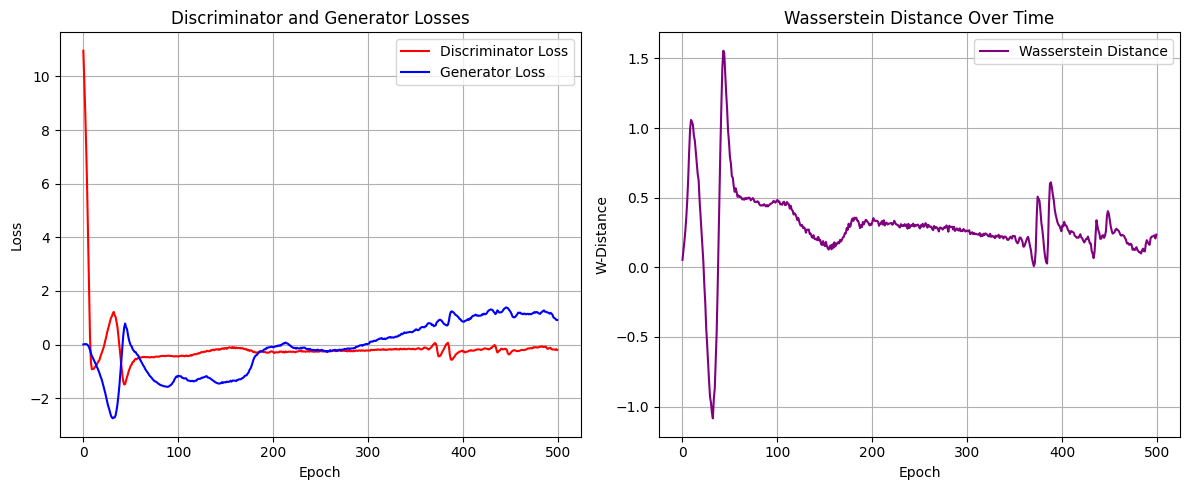

In [16]:
# Plot the loss curves
plot_loss_curves(d_loss_hist, g_loss_hist, wasserstein_hist)

In [17]:
def generate_synthetic_data(generator, num_samples):
    """
    Generate synthetic data using the trained generator.

    Args:
        generator: Trained generator model.
        num_samples: Number of synthetic sequences to generate.

    Returns:
        synthetic_data: Numpy array of shape (num_samples, SEQ_LEN, FEATURE_DIM)
    """
    noise = tf.random.normal([num_samples, SEQ_LEN, LATENT_DIM])
    synthetic_data = generator(noise, training=False).numpy()
    return synthetic_data

In [18]:
num_samples = 1000
synthetic_samples = generate_synthetic_data(generator, num_samples)

In [ ]:
synthetic_samples

- Input: a noise sequence of shape (window_length, latent_dim). In practice, we often set window_length=60 (as in prior work) and latent_dim=1.
- Recurrent layers: Two stacked GRU layers (return_sequences=True) process the input sequence.
- Dense layers: After the RNN, we apply a TimeDistributed Dense with GELU activation to introduce nonlinearity and speed up convergence

- A final TimeDistributed Dense (no activation) maps to the output features.
- Output: a synthetic sequence of shape (window_length, output_dim) (e.g. (60,1)), matching the real data shape



In [19]:
import pandas as pd

# flatten sequence into tabular form
generated_data_flat = synthetic_samples.reshape(-1, len(features))
df_fake = pd.DataFrame(generated_data_flat, columns=features)
# Save to CSV
df_fake.to_csv('RGANdata.csv', index=False)

In [20]:
df_fake

,Value,Value_HeatPump,Value_OtherAppliances
0,0.929448,0.735485,0.624760
1,0.908812,0.869069,0.586367
2,1.009101,1.108556,0.879876
3,0.676280,0.958794,0.688387
4,0.555584,0.920601,0.580129
...,...,...,...
6995,0.378418,0.397960,0.319954
6996,0.411931,0.389124,0.328207
6997,0.318814,0.426619,0.318382
6998,0.207062,0.506384,0.220675


In [21]:
# statistical overlap
def evaluate_statistics(sequence_data,synthetic):
    real_flat = sequence_data.reshape(-1, sequence_data.shape[-1])
    fake_flat = synthetic.reshape(-1, synthetic.shape[-1])

    stats = {}
    for i, feature_name in enumerate(features):
        real_mean = np.mean(real_flat[:, i])
        fake_mean = np.mean(fake_flat[:, i])
        real_std = np.std(real_flat[:, i])
        fake_std = np.std(fake_flat[:, i])

        stats[feature_name] = {
            "real_mean": real_mean,
            "fake_mean": fake_mean,
            "real_std": real_std,
            "fake_std": fake_std
        }
    return stats

In [22]:
# Evaluate
stats = evaluate_statistics(real_sequences, synthetic_samples)
for feat, s in stats.items():
    print(f"{feat}: Real μ={s['real_mean']:.3f}, Fake μ={s['fake_mean']:.3f} | Real σ={s['real_std']:.3f}, Fake σ={s['fake_std']:.3f}")

Value: Real μ=0.359, Fake μ=0.308 | Real σ=0.244, Fake σ=0.270
Value_HeatPump: Real μ=0.349, Fake μ=0.387 | Real σ=0.229, Fake σ=0.310
Value_OtherAppliances: Real μ=0.360, Fake μ=0.358 | Real σ=0.251, Fake σ=0.230


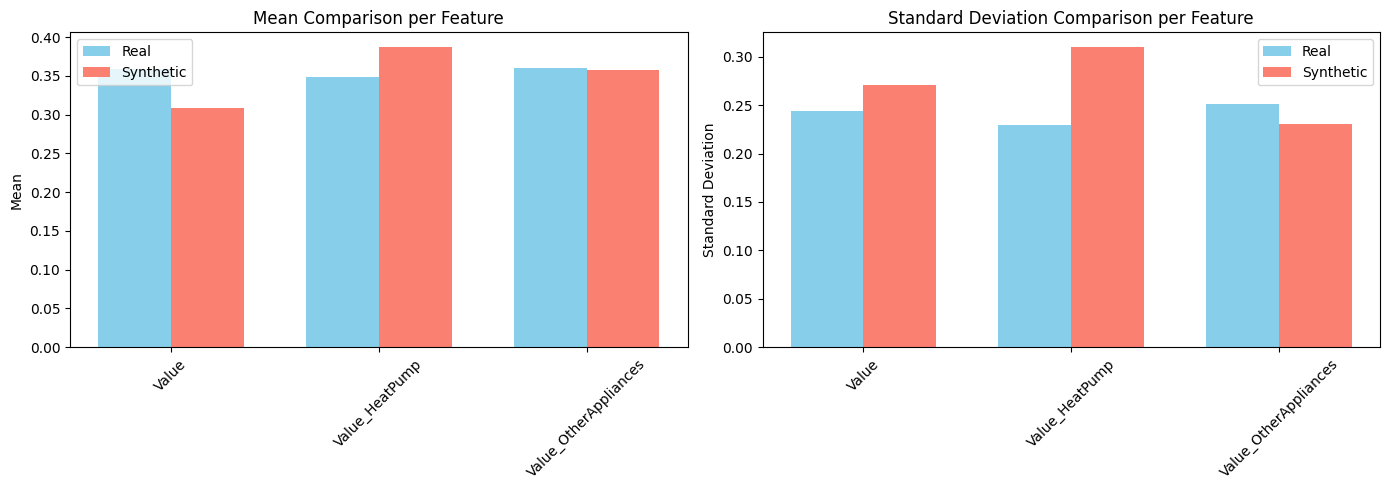

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'stats' is the output dictionary from evaluate_statistics()
features = list(stats.keys())
real_means = [stats[f]['real_mean'] for f in features]
fake_means = [stats[f]['fake_mean'] for f in features]
real_stds = [stats[f]['real_std'] for f in features]
fake_stds = [stats[f]['fake_std'] for f in features]

x = np.arange(len(features))  # label locations
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot means
axs[0].bar(x - width/2, real_means, width, label='Real', color='skyblue')
axs[0].bar(x + width/2, fake_means, width, label='Synthetic', color='salmon')
axs[0].set_ylabel('Mean')
axs[0].set_title('Mean Comparison per Feature')
axs[0].set_xticks(x)
axs[0].set_xticklabels(features, rotation=45)
axs[0].legend()

# Plot stds
axs[1].bar(x - width/2, real_stds, width, label='Real', color='skyblue')
axs[1].bar(x + width/2, fake_stds, width, label='Synthetic', color='salmon')
axs[1].set_ylabel('Standard Deviation')
axs[1].set_title('Standard Deviation Comparison per Feature')
axs[1].set_xticks(x)
axs[1].set_xticklabels(features, rotation=45)
axs[1].legend()

plt.tight_layout()
plt.show()


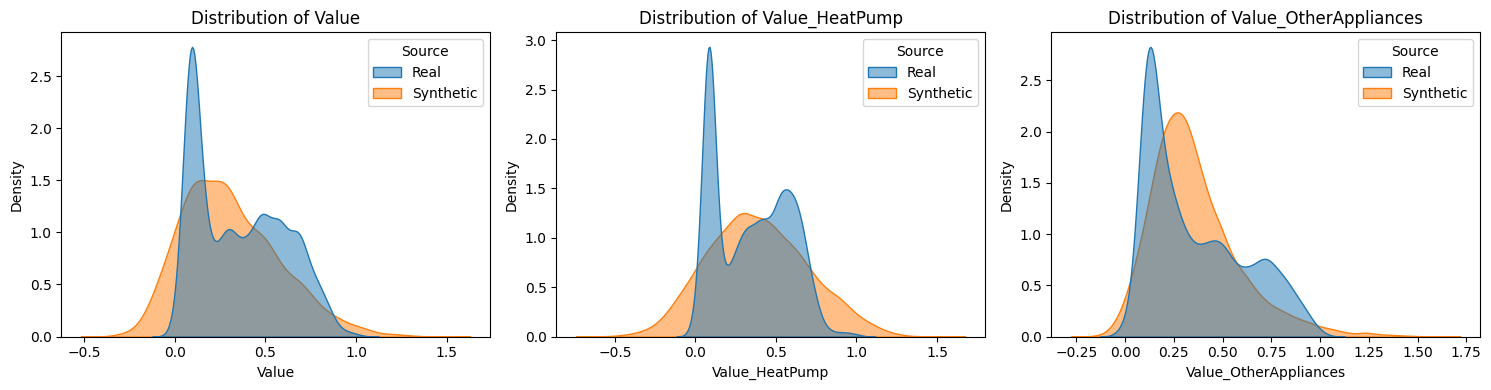

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example variable shapes:
# sequence_data: shape (n_samples, seq_len, n_features)
# synthetic: shape (n_samples, seq_len, n_features)

# Assume feature names are in correct order from `stats.keys()`
feature_names = list(stats.keys())

# Reshape from (samples, time, features) to (samples * time, features)
real_reshaped = real_sequences.reshape(-1, real_sequences.shape[2])
synthetic_reshaped = synthetic_samples.reshape(-1, synthetic_samples.shape[2])

# Create DataFrames
real_df = pd.DataFrame(real_reshaped, columns=feature_names)
real_df["Source"] = "Real"

synthetic_df = pd.DataFrame(synthetic_reshaped, columns=feature_names)
synthetic_df["Source"] = "Synthetic"

# Combine for plotting
combined_df = pd.concat([real_df, synthetic_df], axis=0)

# Plot distributions
num_features = len(feature_names)
cols = 3
rows = (num_features + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(feature_names):
    plt.subplot(rows, cols, i + 1)
    sns.kdeplot(data=combined_df, x=feature, hue="Source", fill=True, common_norm=False, alpha=0.5)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")

plt.tight_layout()
plt.show()


In [25]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance


# === Metric Functions ===
def kl_divergence(p, q):
    p += 1e-8
    q += 1e-8
    return entropy(p, q)

def js_divergence(p, q):
    p += 1e-8
    q += 1e-8
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

# === Evaluation Function ===
def evaluate_gan_outputs(real_sequences, generated_sequences, feature_names=None):
    if isinstance(real_sequences, tf.Tensor):
        real_sequences = real_sequences.numpy()
    if isinstance(generated_sequences, tf.Tensor):
        generated_sequences = synthetic_samples.numpy()

    real_flat = real_sequences.reshape(-1, real_sequences.shape[-1])
    gen_flat = synthetic_samples.reshape(-1, synthetic_samples.shape[-1])
    n_features = real_flat.shape[-1]

    print("\n📊 RGAN Evaluation Metrics")
    for i in range(n_features):
        real_vals = real_flat[:, i]
        gen_vals = gen_flat[:, i]

        # Histogram for divergence metrics
        # Use density=True for normalized histograms suitable for divergence measures
        bins = np.histogram_bin_edges(np.concatenate([real_vals, gen_vals]), bins="auto")
        real_hist, _ = np.histogram(real_vals, bins=bins, density=True)
        gen_hist, _ = np.histogram(gen_vals, bins=bins, density=True)

        # Although density=True normalizes, explicitly re-normalizing
        # helps handle potential floating point issues and ensures sum is exactly 1.
        real_hist /= (np.sum(real_hist) + 1e-8) # Add small epsilon to avoid division by zero
        gen_hist /= (np.sum(gen_hist) + 1e-8)   # Add small epsilon

        # Metrics
        kl = kl_divergence(real_hist, gen_hist)
        js = js_divergence(real_hist, gen_hist)
        wd = wasserstein_distance(real_vals, gen_vals)

        fname = feature_names[i] if feature_names else f"Feature {i+1}"
        print(f"\n🔹 {fname}")
        print(f"  - KL Divergence        : {kl:.4f}")
        print(f"  - JS Divergence        : {js:.4f}")
        print(f"  - Wasserstein Distance : {wd:.4f}")
        # Removed MSE and MAE output

In [26]:
evaluate_gan_outputs(
    real_sequences=real_sequences,
    generated_sequences=synthetic_samples,  # Changed 'synthetic_samples' to 'generated_sequences'
    feature_names=["Value", "Value_HeatPump", "Value_OtherAppliances"]
)



📊 RGAN Evaluation Metrics

🔹 Value
  - KL Divergence        : 0.3219
  - JS Divergence        : 0.0867
  - Wasserstein Distance : 0.0637

🔹 Value_HeatPump
  - KL Divergence        : 0.4148
  - JS Divergence        : 0.1066
  - Wasserstein Distance : 0.0797

🔹 Value_OtherAppliances
  - KL Divergence        : 0.2496
  - JS Divergence        : 0.0595
  - Wasserstein Distance : 0.0577
